In [2]:
import numpy as np
from pathlib import Path
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.extend(['../../scripts','../../scripts/xenium'])
import readwrite
import preprocessing
cfg = readwrite.config()

In [4]:
# cfg paths
xenium_dir = Path(cfg['xenium_processed_data_dir'])
xenium_raw_data_dir = Path(cfg['xenium_raw_data_dir'])
results_dir = Path(cfg['results_dir'])

# Segmentation, mapping paths
dir_segmentations = {
    dir_segmentation.name: (dir_segmentation)
    for dir_segmentation in xenium_dir.iterdir()
}

# Read resegmentations and RCTD
xenium_paths = {}
umaps = {}
cc_paths = []

for segmentation in (segmentations := xenium_dir.iterdir()):
    for condition in (conditions := segmentation.iterdir()): 
        for panel in (panels := condition.iterdir()):
            for donor in (donors := panel.iterdir()):
                for sample in (samples := donor.iterdir()):
                    
                    k = (segmentation.stem,condition.stem,panel.stem,donor.stem,sample.stem)
                    sample_path = sample / "normalised_results/outs"
                    name = '/'.join(k)

                    xenium_paths[k] = sample_path


xenium_levels = ('segmentation','condition','panel','donor','sample')
# ads = readwrite.read_xenium_samples(xenium_paths,anndata_only=True,transcripts=False,donor_name_as_key=False)

### per donor

In [8]:
# Read umaps
umaps = {}
for k,sample_path in xenium_paths.items():
    file = sample_path / 'analysis/umap/gene_expression_2_components/projection.csv'
    if file.exists():
        umaps[k] = pd.read_csv(file,index_col=0)

# Read RCTD
rctd = {}
for k,path in xenium_paths.items():

    if (references := path.parents[1] / "cell_type_annotation/reference_based").exists():
            
        rctd[k] = {}

        for reference in (references := path.parents[1] / "cell_type_annotation/reference_based").iterdir():
            if reference.stem != 'matched_reference':
                continue
            for method in (methods := reference.iterdir()):
                if method.stem !='rctd_class_aware':
                    continue
                for level in (levels := method.iterdir()):
                    if level.stem != 'Level2':
                        continue
                    cell_type_annotation_file = level / 'single_cell/labels.csv'
                    if cell_type_annotation_file.exists():
                        rctd[k][reference.stem,method.stem,level.stem] = pd.read_parquet(cell_type_annotation_file).set_index('cell_id').iloc[:,0]

Segmentation: proseg_v1, condition: breast, Panel: breast, Method: rctd, Reference: matched_reference, Level: Level2
Segmentation: proseg_v1, condition: NSCLC, Panel: lung, Method: rctd, Reference: matched_reference, Level: Level2
Segmentation: proseg_v1, condition: NSCLC, Panel: chuvio, Method: rctd, Reference: matched_reference, Level: Level2
Segmentation: proseg_v1, condition: NSCLC, Panel: 5k, Method: rctd, Reference: matched_reference, Level: Level2
Segmentation: 10x_5um, condition: breast, Panel: breast, Method: rctd, Reference: matched_reference, Level: Level2


KeyboardInterrupt: 

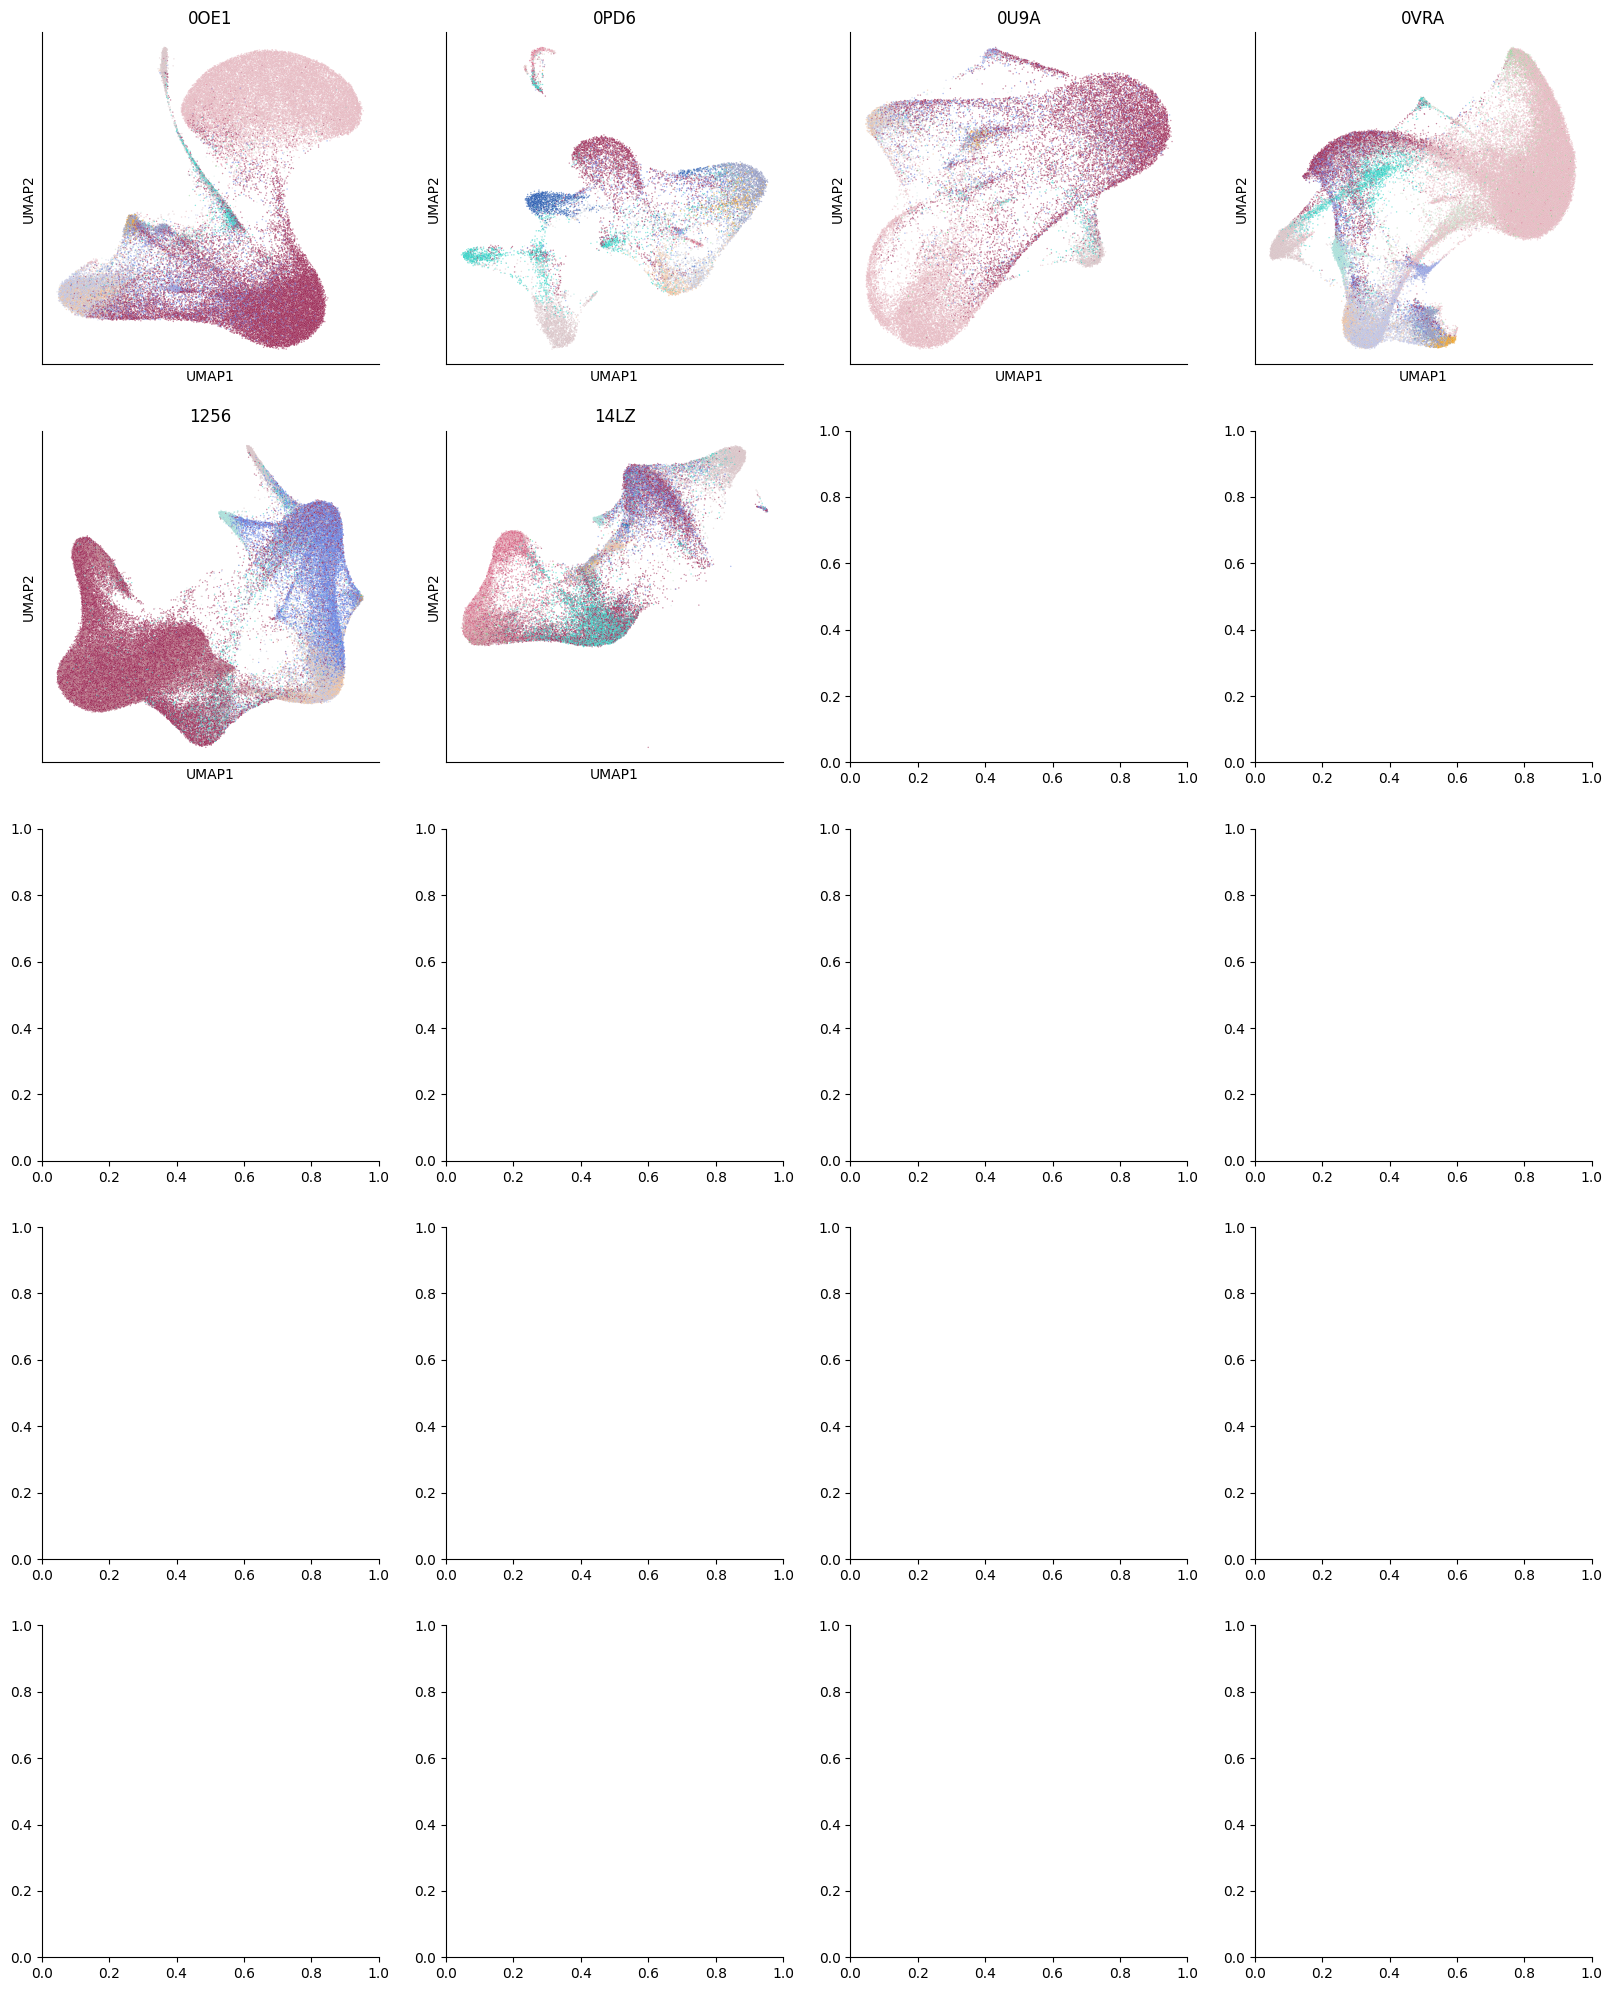

In [7]:
import matplotlib.patches as mpatches

# Define the parameters
references = ['matched_reference','external_reference']
methods = ['rctd']
levels = ['Level2']

# Preprocess and collect all data for consistent palette
df = {}
for k in umaps:
    if k in rctd and len(rctd[k]):
        rctd_df = pd.DataFrame(rctd[k])
        rctd_df.columns = [col for col in rctd_df.columns]
        df[k] = pd.concat((umaps[k], rctd_df), axis=1).dropna()

df = pd.concat(df).reset_index()
df.columns = (*xenium_levels,'cell_id', 'UMAP1', 'UMAP2', *df.columns[8:])

# Extract unique condition and panel combinations
segmentation_condition_panel = df[['segmentation','condition', 'panel']].drop_duplicates()

# Plotting
for reference in references:
    for method in methods:
        for level in levels:
            params = (reference, method, level)

            unique_labels = np.unique(df[params])
            palette = dict(zip(unique_labels,sc.pl.palettes.default_28))
            legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

            for segmentation, condition, panel in segmentation_condition_panel.values:
                print(f"Segmentation: {segmentation}, condition: {condition}, Panel: {panel}, Method: {method}, Reference: {reference}, Level: {level}")

                # Filter data for the current condition and panel
                subset = df.query(f"segmentation == '{segmentation}' and condition == '{condition}' and panel == '{panel}'")

                # Calculate the number of rows and columns dynamically
                n_plots = subset['sample'].nunique()
                n_cols = min(4, n_plots)
                n_rows = int(np.ceil(n_plots / n_cols))

                f, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
                axs = axs.flat if n_plots > 1 else [axs]

                for i, (sample, group) in enumerate(subset.groupby('sample')):
                    ax = axs[i]
                    sns.scatterplot(data=group, x="UMAP1", y="UMAP2", s=1, alpha=.5,
                                    hue=params, ax=ax, palette=palette, legend=False)
                    ax.set_title(sample)
                    ax.xaxis.set_ticks([])
                    ax.yaxis.set_ticks([])
                    sns.despine()

                # Hide unused subplots
                for j in range(n_plots, len(axs)):
                    f.delaxes(axs[j])

                plt.suptitle(f"Segmentation: {segmentation}, condition: {condition}, Panel: {panel}, Method: {method}, Reference: {reference}, Level: {level}")
                f.legend(handles=legend_handles, 
                         loc='center left', 
                         bbox_to_anchor=(1, 0.5), 
                         title=', '.join(params), 
                         frameon=False)
                plt.tight_layout(rect=[0, 0, 0.85, 0.95])
                plt.savefig(cfg['figures_dir'] + f"embed_donor/umap_{segmentation}_{condition=}_{panel=}_{method=}_{reference=}_{level=}.png", dpi=300, bbox_inches='tight')
                plt.close()
                #plt.show()


### per panel

Segmentation: proseg, condition: NSCLC, Panel: lung, Method: rctd_class_aware, Reference: matched_reference, Level: Level2


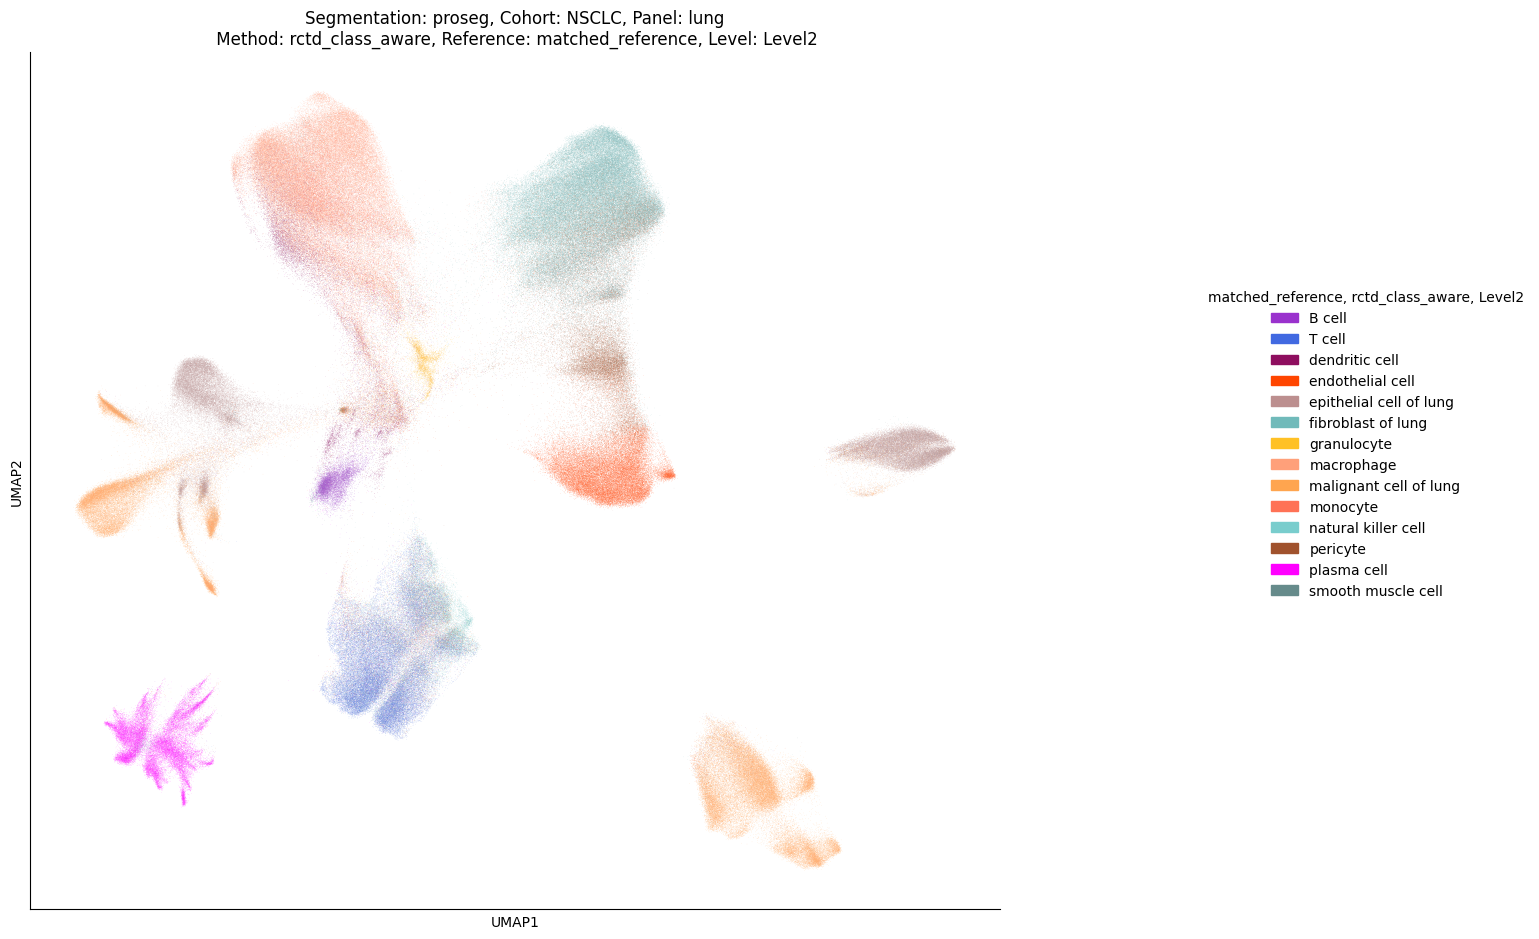

In [30]:
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path

results_dir = cfg['results_dir']
palette_dir = Path(cfg['xenium_metadata_dir'])

# Params
n_comps = 50
n_neighbors = 50
min_dist = 0.3
metric = 'cosine'

# Set up argument parser
# Access the arguments
segmentation = 'proseg'
condition = 'NSCLC'
panel = 'lung'
k = (segmentation,condition,panel)
name = '/'.join(k)

panel = Path(f'/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/{segmentation}/{condition}/{panel}')
embed_file = Path(results_dir) / f'embed_panel/{name}/umap_{n_comps=}_{n_neighbors=}_{min_dist=}_{metric}.parquet'
reference = 'matched_reference'
method = 'rctd_class_aware'
level = 'Level2'
cell_type_palette = palette_dir / 'col_palette_cell_types.csv'
panel_palette = palette_dir / 'col_palette_panel.csv'
sample_palette = palette_dir / 'col_palette_donor.csv'

if level == "sample":
    palette = pd.read_csv(sample_palette, index_col=0).iloc[:, 0]
elif level == "panel":
    palette = pd.read_csv(panel_palette, index_col=0).iloc[:, 0]
else:
    palette = pd.read_csv(cell_type_palette).set_index(level)[f'cols_{level}'].drop_duplicates()


# vars
xenium_levels = ["segmentation", "condition", "panel", "donor", "sample", "cell_id"]
segmentation = panel.parents[1]
condition = panel.parents[0]

# load umap
obs = pd.read_parquet(embed_file)
obs["cell_id"] = obs.index


if level == "sample":
    # plot sample as color, no need to load annotations
    df = obs
    params = level
    title = (
        f"Segmentation: {segmentation.stem}, condition: {condition.stem}, Panel: {panel.stem}"
    )

else:
    # read cell type annotation
    annot = {}
    for donor in (donors := panel.iterdir()):
        for sample in (samples := donor.iterdir()):
            k = (
                segmentation.stem,
                condition.stem,
                panel.stem,
                donor.stem,
                sample.stem,
            )
            name = "/".join(k)

            annot[k] = {}
            annot_file = (
                sample
                / f"cell_type_annotation/reference_based/{reference}/{method}/{level}/single_cell/labels.parquet"
            )
            if annot_file.exists():
                annot[k][reference, method, level] = (
                    pd.read_parquet(annot_file).set_index("cell_id").iloc[:, 0]
                )

    # merge annotations
    df_annot = {}
    for k in annot:
        if len(annot[k]):
            df_ = pd.DataFrame(annot[k])
            df_.columns = [col for col in df_.columns]
            df_annot[k] = df_
    df_annot = pd.concat(df_annot)
    df_annot.index.names = xenium_levels
    df_annot = df_annot.reset_index()

    # merge umap and cell type annotations
    df = pd.merge(obs, df_annot, on=xenium_levels, how="inner")

    params = (reference, method, level)
    title = f"Segmentation: {segmentation.stem}, condition: {condition.stem}, Panel: {panel.stem}\n Method: {method}, Reference: {reference}, Level: {level}"


# plotting params, palette
unique_labels = np.unique(df[params].dropna())
palette = {u: palette[u] for u in unique_labels}
legend_handles = [
    mpatches.Patch(color=color, label=label) for label, color in palette.items()
]

print(
    f"Segmentation: {segmentation.stem}, condition: {condition.stem}, Panel: {panel.stem}, Method: {method}, Reference: {reference}, Level: {level}"
)


# plot
f = plt.figure(figsize=(12, 10))
ax = plt.subplot()

sns.scatterplot(
    data=df,
    x="UMAP1",
    y="UMAP2",
    s=0.1,
    alpha=0.5,
    hue=params,
    ax=ax,
    palette=palette,
    legend=False,
)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
sns.despine()

plt.title(title)
f.legend(
    handles=legend_handles,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title=params if isinstance(params, str) else ", ".join(params),
    frameon=False,
)
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
# plt.savefig(out_file, dpi=300, bbox_inches="tight")
plt.show()

